# Cat and Dog Classification

### Package Set Up

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

import pandas as pd
import numpy as np
np.random.seed(13)

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import sequence, image_dataset_from_directory
import os
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.utils import shuffle

from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import os
import shutil
import tensorflow as tf
from tensorflow import keras
import math
import keras.applications.xception as xception

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Change folder directory format to use flow_from_directory function




In exploring different ways to load image files into a data scrutcure I discoved generators in the Keras package. I was able to store all of the training and testing data into the generator objects. I used the flow_from_directory method from Keras to generate these generators. To do this I first had to set up the training folders into the proper file structure, which I intially did on my local machine, after realizing the long run times I moved my work onto Google Drive and Google Colab.

In [ ]:
# dog_path = r'C:\Users\garet\handson-ml2\MSBA 6420\Homework\HW4\train\dog'
# cat_path = r'C:\Users\garet\handson-ml2\MSBA 6420\Homework\HW4\train\cat'

In [ ]:
# https://www.geeksforgeeks.org/create-a-directory-in-python/
# os.mkdir(dog_path)
# os.mkdir(cat_path)

In [ ]:
# help with file moving from here: https://stackoverflow.com/questions/8858008/how-to-move-a-file-in-python
# parent_dir = r'C:\Users\garet\handson-ml2\MSBA 6420\Homework\HW4\train'
# cat_dir = r'C:\Users\garet\handson-ml2\MSBA 6420\Homework\HW4\train\cat'
# dog_dir = r'C:\Users\garet\handson-ml2\MSBA 6420\Homework\HW4\train\dog'
# for file in os.listdir('./train/'):
#     if file.endswith('.jpg'):
#         if file.startswith('cat'):
#             shutil.move(parent_dir+'\\' +file, cat_dir+'\\' +file)
#         else:
#             shutil.move(parent_dir+'\\' +file, dog_dir+'\\' +file)

## Training Data Set Up

In [ ]:
train_path = '/content/drive/MyDrive/MSBA 6420 Predictive Analytics/Homework/HW4/train'
test_path = '/content/drive/MyDrive/MSBA 6420 Predictive Analytics/Homework/HW4/test'

In [ ]:
# found from documentation: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#used-in-the-notebooks_1
datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.1 #, preprocessing_function=xception.preprocess_input
)

train_generator = datagen.flow_from_directory(
        train_path,
        target_size=(150, 150),
        batch_size=64,#32 #50
        class_mode='binary',
        subset="training",
        seed=45,
        color_mode='rgb',
        classes=['cat','dog'])

validation_generator = datagen.flow_from_directory(
        train_path,
        target_size=(150, 150),
        batch_size=64,# 32 #50
        class_mode='binary',
        subset="validation",
        seed=45,
        color_mode='rgb',
        classes=['cat','dog'])

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


## Model Building

For the model building in this question I first started with a simple CNN model 2 convultion layers, followed by a max pooling layer and a flattening layer, and fed that into a regular feedforward neural network. With this simple network I was able to achieve a score of .69 in the kaggle submission. After such a weak performance I decided to use the prebuilt Xception model. After running this model with a batch size of 32, 5 epochs, and a steps_per_epoch of 100 I was able to achieve a score of .1 in the submission. After doing some more hyperparameter tunning I was able to get my score down to .08 by setting the batch size to 50 the epochs to 10, and steps_per_epoch to 200. My final score of .078 was achieved by setting the batch size to 64 the epochs to 4, and setting steps_per_epoch the training and validation set sized divided by the batch size. 

In [ ]:
nb_classes = 1

In [ ]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(nb_classes, activation="sigmoid")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83697664/83683744 [==============================] - 1s 0us/step


In the following code block I used the SGD optimizer that was implemented in the sample code given by the text book - "Hands-on machine learning with Scikit-Learn, Keras and TensorFlow" - O’Reilly.


In [ ]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

## Training the Model

In [ ]:
model.fit(train_generator,
        steps_per_epoch=(22500 / 64),
        epochs=4,
        validation_data=validation_generator,
        validation_steps=(2500 / 64))

Epoch 1/4
351/351 [==============================] - 3844s 11s/step - loss: 0.1371 - accuracy: 0.9439 - val_loss: 0.0709 - val_accuracy: 0.9740
Epoch 2/4
351/351 [==============================] - 193s 547ms/step - loss: 0.0526 - accuracy: 0.9804 - val_loss: 0.0560 - val_accuracy: 0.9768
Epoch 3/4
351/351 [==============================] - 193s 548ms/step - loss: 0.0316 - accuracy: 0.9888 - val_loss: 0.0555 - val_accuracy: 0.9780
Epoch 4/4
351/351 [==============================] - 194s 550ms/step - loss: 0.0280 - accuracy: 0.9898 - val_loss: 0.0527 - val_accuracy: 0.9824


## Testing Data Set Up

Used the flow_from_dataframe method to turn the testing data into a generator

In [ ]:
test_img_list = []
for i in range(1,12501):
    test_img_list.append(str(i)+'.jpg')

In [ ]:
test_img_df = pd.DataFrame({'filename':test_img_list})

In [ ]:
datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_generator = datagen.flow_from_dataframe(test_img_df,
        directory=test_path,
        x_col='filename',
        y_col=None,
        target_size=(150, 150),
        batch_size=64,
        class_mode=None,
        seed=45,
        shuffle=False,
        color_mode='rgb')

Found 12500 validated image filenames.


## Getting Predictions on Testing Data, and Storing to Dataframe

In [ ]:
results = model.predict(test_generator)
results = results.squeeze()
results_list = results.tolist()

In [ ]:
id_test = list(range(1,12501))

In [ ]:
results_df = pd.DataFrame(list(zip(id_test, results_list)), columns =['id', 'label'])

In [ ]:
results_df.head(10)

,id,label
0,1,0.999892
1,2,0.999022
2,3,0.997478
3,4,0.999687
4,5,0.000131
5,6,0.000011
6,7,0.000002
7,8,0.000002
8,9,0.000002
9,10,0.000016


## Output Results File


In [ ]:
output_path = '/content/drive/MyDrive/MSBA 6420 Predictive Analytics/Homework/HW4/MSBA.Session2.garett_carlblom.csv'

In [ ]:
results_df.to_csv(output_path, index=False)

## Displaying Results on Test Images


I used the following code to print out the first few images, and what the model predicted each image to be along with it's probability prediction. This gives a good sense how well the model is performing on the Test data before the submission

In [ ]:
test_image_list = []
for i in range(1, 25001):
    test_image_list.append('/content/drive/MyDrive/MSBA 6420 Predictive Analytics/Homework/HW4/test'+'/' + str(i)+'.jpg')

In [ ]:
pet_list = []
for item in results_list:
    if item >.5:
        pet_list.append('dog')
    else:
        pet_list.append('cat')

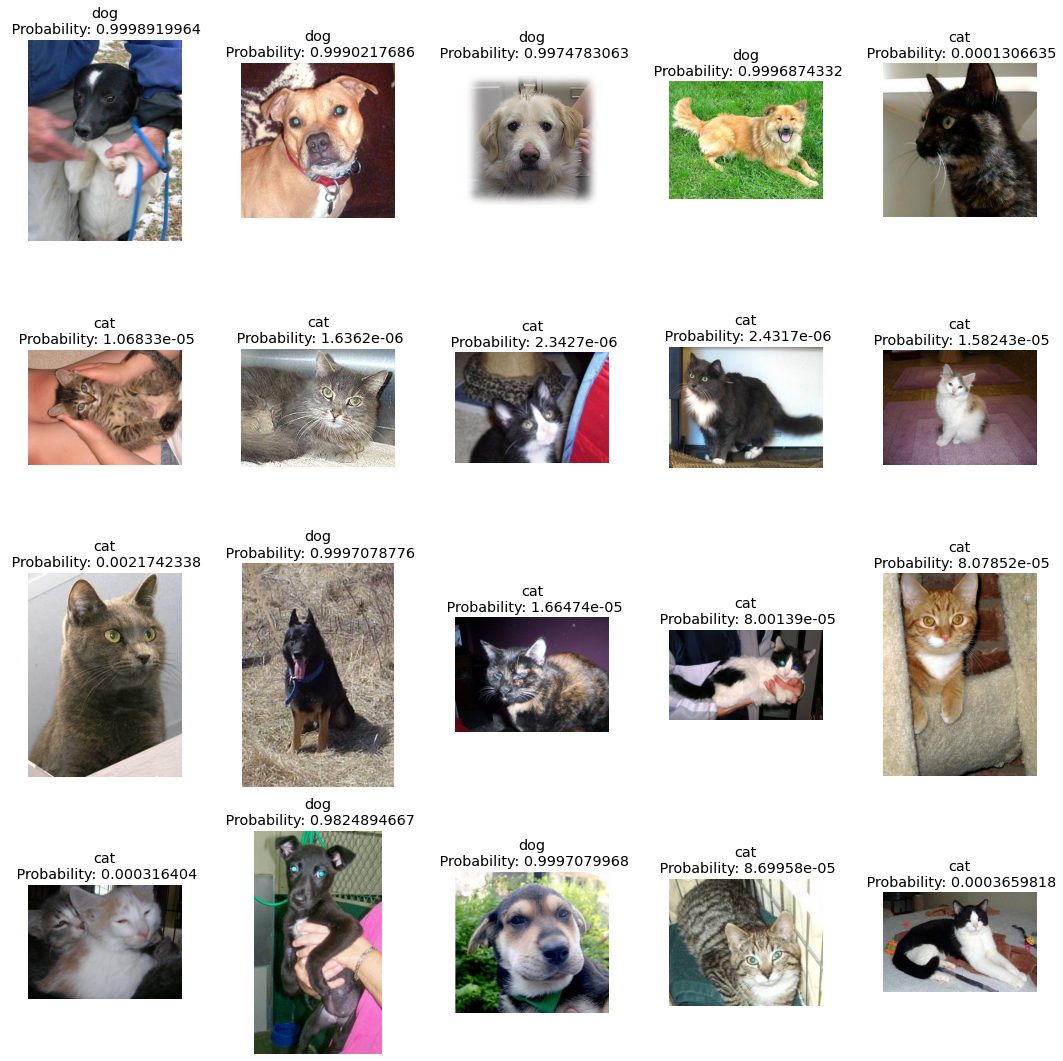

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(load_img(test_image_list[i]))
    plt.title(pet_list[i] +  '\n ' + 'Probability: '+str(round(results_list[i], 10)))
    plt.axis('off')
plt.tight_layout()